<h1 style='text-aling:center;color:Navy'>  Big Data Systems = Crystin VanWagenen </h1>

# <span style="color:#3665af">MongoDB </span><span style="font-size:15px">(Estimated time: 4 hours) </span>
<hr>
The objective of this assignment is to introduce the use of sharding in MongoDB by studing the behavior of key and hash sharding. 

We start by a guided study of the cluster configuration and the sharding process, by using the cities.txt dataset we used in lab #2. Later, the assignment requires you to apply what you learn in the guide by implementing a sharded cluster for a particular setting. 

<b><u>Notebook Layout (Table of Contents):</u></b>
1. Environment Set-up
   - Creating Virtual Machine
   - Installing MongoDB
2. Studying Data Sharding using MongoDB
   - Context
3. Guided tour on MongoDB sharding mechanisms
   - Preparing a database
   - Configuring a sharded cluster
   - Sharding a database collection
   - Balancing data across sharded cluster
4. Saharding in real-world application


<div style="font-size:30px;color:#3665af;background-color:#E9E9F5;padding:10px;">1. Environment Set-up </div>

For this assignment we will be using MongoDB on a virtual machine (VM) working on the Google Cloud. Please follow the instructions to set up the VM. You can always opt and install MongoDB on your own system. We don't recommend the latter.<br><br>

<div style="font-size:20px;color:#F1F8FC;background-color:#0095EA;padding:10px;">1.1. Creating Virtual Machine </div>
We will create a virtual machine with this configuration:
- **Name**: mongodbsvr
- **Zone**: us-central1-f
- **Machine Type**: 1vCPU with 3.75GB ram
- **Boot Disk**: Ubuntu 16.04LTS 10GB persistent Disk (you need to change this)

All the other parameters set to default. The estimated cost ir around $0.034 per hour. Your Cloud Compute VM creation screen should be similar to this:<br>

<img src="img/mongodbsvr.png", style="width:850px;">




<div style="font-size:20px;color:#F1F8FC;background-color:#0095EA;padding:10px;">1.2. Installing MongoDB </div>
Once you have your machine, we will open an SSH terminal. Go to the VM list and click the SSH icon. We will be using several terminals for this assignment, so be ready to repeat this several times and to keep track of what we are doing with each terminal.

![terminal](img/terminal.png)


Once you are in the terminal first thing to do is to install MongoDB. We will be using version 2.6 for this assignment, which can be installed by using _apt_ on Ubuntu. So, run the following command:

<pre style="background-color: #ebece4;padding: 10px;border-left: solid 4px orange;">
sudo apt install --yes mongodb-server mongodb-clients
</pre>
Once the program end you should get an output similar to the following, meaning the MongoDB server and client were installed successfully.

<pre style="background-color: #000000;color:#F2F7F9;padding:10px;">
Adding system user `mongodb' (UID 113) ...
Adding new user `mongodb' (UID 113) with group `nogroup' ...
Not creating home directory `/var/lib/mongodb'.
Adding group `mongodb' (GID 117) ...
Done.
Adding user `mongodb' to group `mongodb' ...
Adding user mongodb to group mongodb
Done.
Processing triggers for libc-bin (2.23-0ubuntu10) ...
Processing triggers for systemd (229-4ubuntu21.1) ...
Processing triggers for ureadahead (0.100.0-19) ...
</pre>


<div style="font-size:30px;color:#3665af;background-color:#E9E9F5;padding:10px;">
    2. Studying <b>Data Sharding</b> using MongoDB</div>
<br>
<div style="font-size:20px;color:#F1F8FC;background-color:#0095EA;padding:10px;">
    2.1. Context 
</div>

NoSQL databases started gaining popularity in the 2000’s when companies began investing in distributed databases. An important aspect of NoSQL databases is that they have no predefined schema. Records can have different fields as necessary. NoSQL databases, apart from using an Application Programming Interface(API) or query language to access and modify data, may also use Map-Reduce which is used for performing a specific function on an entire dataset.


Sharding is a _method_ for storing a large collection of data across multiple servers called **shards** (cf. image below). This allows increased performance as each server handles different sets of data.

![shards](img/shards.png)


<div style="font-size:30px;color:#3665af;background-color:#E9E9F5;padding:10px;">
    3. Guided tour on MongoDB sharding mechanisms</div>
<br>
<div style="font-size:20px;color:#F1F8FC;background-color:#0095EA;padding:10px;">
    3.1. Preparing a database
</div>

MongoDB stores documents using its own binary format called BSON. This format is a binary version of the widely used JSON (JavaScript Object Notation) format and its name stands for Binary JSON. Although MongoDB uses BSON internally, the manipulation of documents in the MongoDB shell interface and client software is done using JSON due to its readability and open standard. In MongoDB databases are composed of collections of documents.

**For this exercise, first you have to (i) create a database and then (ii) create and populate a database collection.** We are going to use a data collection called cities.

<div style="font-size:20px;color:#0095EA;padding:10px;">
    3.1.1 Creating and populating a documents database
</div>

#### 3.1.1.1 Creating and populating a documents database
- Start a MongoDB instance:
<pre style="background-color: #ebece4;padding: 10px;border-left: solid 4px orange;">
mkdir -p ~/db/shard1                             # Folder containing the DB files 
mongod --shardsvr --dbpath ~/db/shard1 --port 27021
</pre>
_Note:_ the instance will be used later as a shard server (option --shardsvr)

#### 3.1.1.2 Creating a database and database collection

- Using a new shell, connect to the MongoDB instance:

<pre style="background-color: #ebece4;padding: 10px;border-left: solid 4px orange;">
mongo --host localhost:27021
</pre>

- Create the database mydb and the database collection cities:

<pre style="background-color: #ebece4;padding: 10px;border-left: solid 4px orange;">
use mydb # Create the DB if not exists db.createCollection("cities")
</pre>

- Verify the existence of the database (mydb) and the database collection (cities):

<pre style="background-color: #ebece4;padding: 10px;border-left: solid 4px orange;">  
show dbs
show collection
</pre>


#### 3.1.1.3 Populateing the database

- Using a new shell, import the content of the file cities.txt into mydb.cities collection. After that close the shell:

<pre style="background-color: #ebece4;padding: 10px;border-left: solid 4px orange;">
mongoimport --host localhost:27021 --db mydb --collection cities --file ~/cities.txt
</pre>

**_Note:_** you need the file cities.txt. Review Lab #2 to get that file from the bucket. 

- After the import is done, you can close that terminal.
- Using the other terminal check that the data was loaded correctly. You learned in Lab #2 how to do that.

<div style="font-size:20px;color:#F1F8FC;background-color:#0095EA;padding:10px;">
    3.2. Configuring a sharded cluster
</div>

As discussed in the course, MongoDB supports sharding through a sharded cluster. A sharded cluster is composed of the following components:
- Shards: store the data.
- Query routers: direct operations from clients to the appropriate shard(s) and return results to clients.
- Config servers: store cluster’s metadata. The query router uses this metadata to target operations to specific shards.

_Note:_ In a real-life scenario, each of these services we are going to be configuring and starting should reside in an individual server. However, in our case we will lunch all of them in this sole VM.


<img src="img/shardcluster.png" style="width:550px;">

For the sake of simplicity you will configure with a simple sharded cluster (cf. image below) composed of:
- One config server
- One query router (mongos instance)
- One shard (mongod instance)

<div style="font-size:20px;color:#0095EA;padding:10px;">
    3.2.1. Starting a config server instance
</div>

- Using a **new shell**, start a config server (mongod instance):

<pre style="background-color: #ebece4;padding: 10px;border-left: solid 4px orange;">
mkdir -p ~/db/configdb
mongod --configsvr --dbpath ~/db/configdb --port 27020
</pre>

<div style="font-size:20px;color:#0095EA;padding:10px;">
    3.2.2. Starting a query router instance
</div>

- Using a **new shell**, start a query router (mongos instance) connected to the config server instance in port 27020:

<pre style="background-color: #ebece4;padding: 10px;border-left: solid 4px orange;">
mongos --configdb localhost:27020 --port 27019
</pre>

<div style="font-size:20px;color:#0095EA;padding:10px;">
    3.2.3. Adding a shard instance to the cluster
</div>

- Using a **new shell**, connect to the query router (mongos instance):

<pre style="background-color: #ebece4;padding: 10px;border-left: solid 4px orange;">
mongo --host localhost:27019
</pre>

- Add to the cluster the mongo instance containing the **mydb** database:

<pre style="background-color: #ebece4;padding: 10px;border-left: solid 4px orange;">
use admin
db.runCommand( { addShard: "localhost:27021", name: "shard1" } )
</pre>

- Verify the state of the cluster:

<pre style="background-color: #ebece4;padding: 10px;border-left: solid 4px orange;">
sh.status()
</pre>

<div style="font-size:20px;background-color:#A74A54;color:#F1E6E7;padding:10px;">
    Question 1:
</div>

**What is an important information reported by this command?**

<hr>

<div style="font-size:20px;color:#F1F8FC;background-color:#0095EA;padding:10px;">
    3.3. Sharding a database collection
</div>

Recall that sharding is enabled in MongoDB on a per-basis collection. When sharding is enabled on a collection, MongoDB partitions the data into the shards of a cluster using a **shard key**, an indexed field that exists in every document stored in the collection.

MongoDB divides the shard key values into **chunks** (of documents) and distributes the chunks evenly across shards. To divide the shard key values into chunks, MongoDB uses two kinds of partitioning strategies:

- **Range based partitioning:** data is partitioned into ranges [min, max] determined by the shard key. Each range represents a chunk.

<img src="img/range_based.png" style="width:550px;">

<br><br>

- **Hash based partitioning:** data is partitioned into chunks using a hash function.

<img src="img/hash_based.png" style="width:550px;">


In what follows you will shard copies of the collection mydb.cities using range based and hash based partitioning.

<div style="font-size:20px;color:#0095EA;padding:10px;">
    3.3.1. Sharding a collection using range-based partition
</div>

- Using the **shell connected to the query router**(mongos instance), create the collection **cities1** in database **mydb**:

<pre style="background-color: #ebece4;padding: 10px;border-left: solid 4px orange;">
use mydb
db.createCollection("cities1")
show collections # Verify collection existence
</pre>

- Enable sharding on the collection **mydb.cities1** using the attribute **state** as *shard key*:

<pre style="background-color: #ebece4;padding: 10px;border-left: solid 4px orange;">
sh.enableSharding("mydb") 
sh.shardCollection("mydb.cities1", { "state": 1} )
</pre>

- Verify the **number of chunks**:

<pre style="background-color: #ebece4;padding: 10px;border-left: solid 4px orange;">
sh.status()
</pre>

<div style="font-size:20px;background-color:#A74A54;color:#F1E6E7;padding:10px;">
    Question 2:
</div>

a) **How many chunks did you create?**
I created 1 chunk. 

b) **What are their associated ranges?**
The associated ranges are MinKey to MaxKey.

Include a screenshot of the results of the command in your answer to support your answer.

- Populate the collection **cities1** using the content of the collection **mydb.cities** (we loaded that collection with _mongoimport_ tool before):

<pre style="background-color: #ebece4;padding: 10px;border-left: solid 4px orange;">
db.cities.find().forEach( 
                         function(d) {
                                      db.cities1.insert(d); 
                                     }
                         )
</pre>

- Verify the **number of chunks** after population:

<pre style="background-color: #ebece4;padding: 10px;border-left: solid 4px orange;">
sh.status()
</pre>

<div style="font-size:20px;background-color:#A74A54;color:#F1E6E7;padding:10px;">
    Question 3:
</div>

a) **How many chunks are there now?**  
There are 3 chunks.

b) **What are their associated ranges?**
The 3 associated ranges are minKey -> "MA", "MA -> "VT", and "VT -> maxKey.

c) **What are the changes you can observe?**
Apart from the new chunks each chunk appears to apply a cut off for each range.

Include a screenshot of the results of the command in your answer to support your answer.

<div style="font-size:20px;color:#0095EA;padding:10px;">
    3.3.2. Sharding a collection using hash-based partition
</div>

Now let's study the sharding strategy using a hash function.

- Using the **shell connected to the query router**(mongos instance), create the collection **cities2** in database **mydb**:

<pre style="background-color: #ebece4;padding: 10px;border-left: solid 4px orange;">
use mydb
db.createCollection("cities2")
show collections # Verify collection existence
</pre>

- Enable sharding on the collection **mydb.cities2**.The principle that we will adopt is to use the attribute **state** as shard key.

<pre style="background-color: #ebece4;padding: 10px;border-left: solid 4px orange;">
sh.enableSharding("mydb") 
sh.shardCollection("mydb.cities2", { "state": "hashed"} )
</pre>

**Note the difference between the command that shards by range and the one to shards by hash.**


- Verify the **number of chunks** before the population: 

<pre style="background-color: #ebece4;padding: 10px;border-left: solid 4px orange;">
sh.status()
</pre>

<div style="font-size:20px;background-color:#A74A54;color:#F1E6E7;padding:10px;">
    Question 4:
</div>

a) **How many chunks did you create?**

There were 2 chunks created 

b) **What differences do you see with respect to the same task in the range sharding strategy?**
The difference with the hashing is that with each hash, it is given a NumberLong as a value (for what appears to be a range). 

Include a screen copy of the results of the command in your answer to support your answer.

<div style="font-size:20px;background-color:#0B6713;color:#F1E6E7;padding:10px;">
    TO-DO:
</div>

a) **Populate the collection _cities2_**  

Place your code below.

<div style="font-size:20px;background-color:#A74A54;color:#F1E6E7;padding:10px;">
    Question 5:
</div>

a) **How many chunks are there now?**

Now there are 3 chunks.

b) **Compare the result with respect to the range sharding. Explain what you see different.**

The hash using a range with a number value that it determined was the best split, versus Range which uses the range that was assigned to it.

Include a screen shot of the results of the command in your answer to support your answer. 



<div style="font-size:20px;color:#F1F8FC;background-color:#0095EA;padding:10px;">
    3.4. Balancing data across sharded cluster
</div>
Balancing is the process MongoDB uses to distribute data of a sharded collection evenly across a sharded cluster. When a shard has too many of a sharded collection’s chunks compared to other shards, MongoDB automatically balances the chunks across the shards.

MongoDB balancer supports **tagging** a range of shard key values. Using *tags* you can:
- Isolate specific subset of data on a specific set of shards.
- Ensure that relevant data reside on shards that are geographically close to the user.

For the final part of this exercise you will analyze the behavior of the *MongoDB balancing process* by adding *tagged shards* to your cluster.

<div style="font-size:20px;color:#0095EA;padding:10px;">
    3.4.1. Adding shards to a cluster
</div>

- Using a **new shell**, start *another* MongoDB instance:

<pre style="background-color: #ebece4;padding: 10px;border-left: solid 4px orange;">
mkdir -p ~/db/shard2
mongod --shardsvr --dbpath ~/db/shard2 --port 27022
</pre>

- Using a **new shell **(mongos instance), add the new _mongo instance_ to the cluster:

<pre style="background-color: #ebece4;padding: 10px;border-left: solid 4px orange;">
use admin
db.runCommand( { addShard: "localhost:27022", name: "shard2" } )
</pre>


- Wait a few seconds and check the status of the cluster: 

<pre style="background-color: #ebece4;padding: 10px;border-left: solid 4px orange;">
sh.status()
</pre>

<div style="font-size:20px;background-color:#A74A54;color:#F1E6E7;padding:10px;">
    Question 6:
</div>

**Draw the new configuration of the cluster and label each element (_router, config server and shards_) with its corresponding port as you defined in the previous tasks.**

_Note:_ you can present this as a table if it is easier than drawing, or you can insert an image.


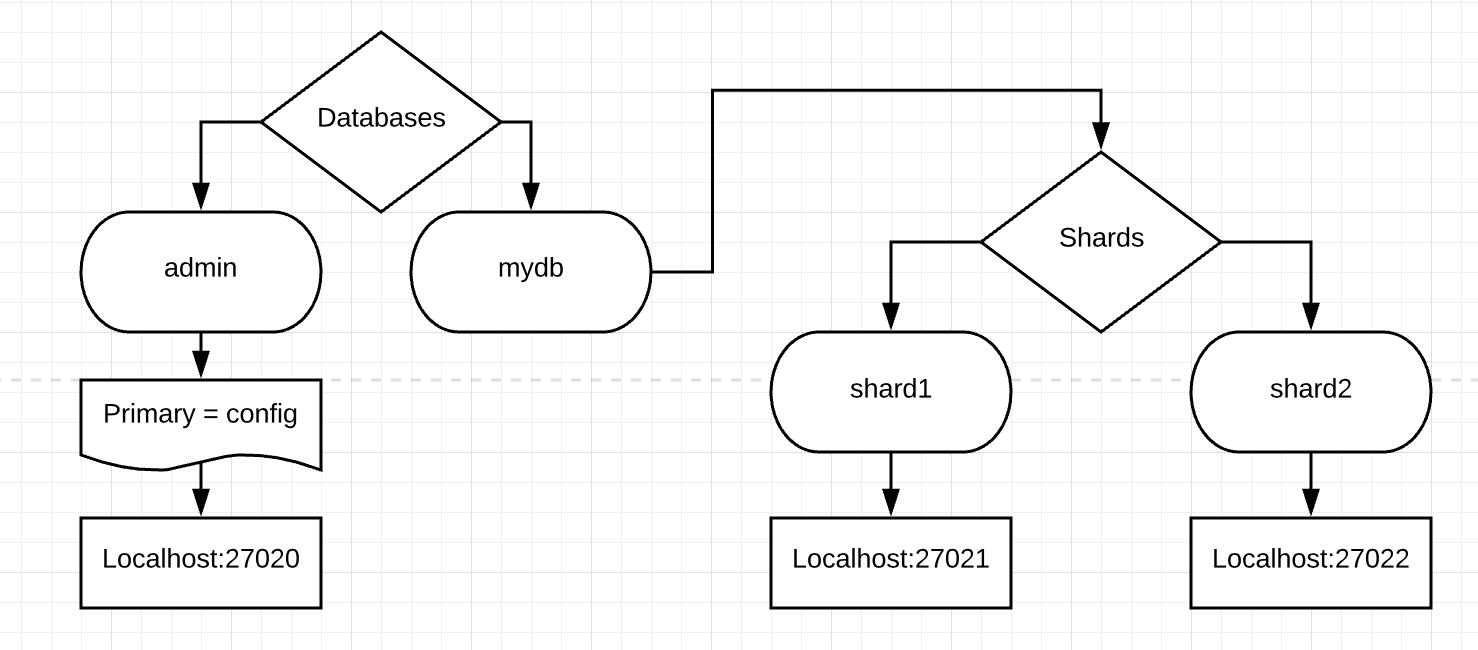

In [4]:
from IPython.display import Image
Image(filename='/Users/crystinrodrick/Desktop/Screen Shot 2018-03-12 at 1.25.40 PM.png')

<div style="font-size:20px;color:#0095EA;padding:10px;">
    3.4.2. Sharding using taged shards
</div>

- Using a **new shell**, start *another* MongoDB instance:

<pre style="background-color: #ebece4;padding: 10px;border-left: solid 4px orange;">
mkdir -p ~/db/shard3
mongod --shardsvr --dbpath ~/db/shard3 --port 27023
</pre>

<div style="font-size:20px;background-color:#0B6713;color:#F1E6E7;padding:10px;">
    TO-DO:
</div>

- Using a **new shell **(mongos instance), add the new _mongo instance_ to the cluster:

Place your code bellow.


- Using a **new shell **(mongos instance), associate tags to shard instances:

<pre style="background-color: #ebece4;padding: 10px;border-left: solid 4px orange;">
sh.addShardTag("shard1", "CA") 
sh.addShardTag("shard2", "NY") 
sh.addShardTag("shard3", "Others")
</pre>

- Create, shard and populate a new collection named **cities3**:

<pre style="background-color: #ebece4;padding: 10px;border-left: solid 4px orange;">
use mydb;
db.createCollection("cities3") 

sh.shardCollection("mydb.cities3", { "state": 1} )

db.cities.find().forEach(
                         function(d) { 
                                       db.cities3.insert(d); 
                                     } 
                        )
</pre>

- Associate **shard key ranges** to tagged shards:

<pre style="background-color: #ebece4;padding: 10px;border-left: solid 4px orange;">
sh.addTagRange("mydb.cities3", { state: MinKey }, { state: "CA" }, "Others") 
sh.addTagRange("mydb.cities3", { state: "CA" }, { state: "CA_" }, "CA") 
sh.addTagRange("mydb.cities3", { state: "CA_" }, { state: "NY" }, "Others") 
sh.addTagRange("mydb.cities3", { state: "NY" }, { state: "NY_" }, "NY") 
sh.addTagRange("mydb.cities3", { state: "NY_" }, { state: MaxKey }, "Others")
</pre>

- Review the configuration of the cluster

<pre style="background-color: #ebece4;padding: 10px;border-left: solid 4px orange;">
sh.status()
</pre>

<div style="font-size:20px;background-color:#A74A54;color:#F1E6E7;padding:10px;">
    Question 7:
</div>

**a)** Analyze the results and explain the logic behind this tagging strategy. 

The tagging strategy is to separate by two states vs all other states. In other words, one tag holds lines where state = CA, another where state = NY and the third where state doesn't equal CA or NY.


**b)** Connect to the shard that contains the data about California (the mongo server running that shard, e.g. shard2 server running on port 27022), and count the documents. 

For Cities 1, shard2, there are 10466 documents.
For Cities 2, shard2, there are 14897 documents.
 

**c)** Do the same operation with the other shards. 

For Cities 1, shard1, there are 2239 documents.
For Cities 2, shard1, there are 9419 documents.
For Cities 1, shard3, there are 16648 documents.
For Cities 2, shard3, there are 5037 documents.
For Cities 3, shard1, there are 3698 documents.
For Cities 3, shard3, there are 6778 documents.

**d)** Is the sharded data collection complete with respect to initial one? 

The sharded data is complete with respect to the original one, because they both hold the same amount of data and documents. 

Cities1
    data : 3.13MiB docs : 29353 chunks : 3
Cities2
    data : 3.13MiB docs : 29353 chunks : 3

**d)** Are shards orthogonal?

YES


<div style="font-size:30px;color:#3665af;background-color:#E9E9F5;padding:10px;">
    4. Sharding in real-world application
</div>

Considering the dataset from Amazon Kindle Stories Reviews (available [here](https://www.kaggle.com/bharadwaj6/kindle-reviews/downloads/kindle_reviews.json)), you should load the dataset into a mongo, and define a sharded cluster based on what we just implemented.

**Answer the following questions about your implementation. You can also use them as a guideline:**
1. Explain your reasons for choosing your sharding key. _Which are possible implications when querying data and when adding/deleting data?_

2. Implement a cluster with 3 shards and distribute the data across them according to your chosen key using **both the range and hash based strategies**.

3. Populate your sharded database using the data collection you downloaded.

4. **Compare the behavior of your sharding solution in the range-based strategy versus that of the hash-based strategy**:
   1. Once you populate the sharded database, is the result balanced?
   2. Give an example of query or a manipulation operation that can potentially benefit from your sharding strategy. Test your hypothesis and present the result of running the operation with and without sharding (include screenshots of the results).
   3. In which cases your sharding is useless for scaling the management of the data collection? Give examples to support your arguments.
   4. Define a criterion for defining critical documents and use the tagging strategy for isolating these data. Show evidence of the operation and results.

1. Explain your reasons for choosing your sharding key. Which are possible implications when querying data and when adding/deleting data?
   The original sharding key I used was "reviewerID". I used this to analyze each reviewer. This will allow to make recommender systems. When adding, it will be easy to sort.

2. Implement a cluster with 3 shards and distribute the data across them according to your chosen key using both the range and hash based strategies.
    This is done in the code above. 
    --- Sharding Status --- 
  sharding version: {
        "_id" : 1,
        "version" : 4,
        "minCompatibleVersion" : 4,
        "currentVersion" : 5,
        "clusterId" : ObjectId("5aa6a18e93cd80281225aad5")
}
  shards:
        {  "_id" : "shard1",  "host" : "localhost:27021",  "tags" : [ "A1" ] }
        {  "_id" : "shard2",  "host" : "localhost:27022",  "tags" : [ "AG" ] }
        {  "_id" : "shard3",  "host" : "localhost:27023",  "tags" : [ "AN" ] }
  databases:
        {  "_id" : "admin",  "partitioned" : false,  "primary" : "config" }
        {  "_id" : "mydb",  "partitioned" : true,  "primary" : "shard1" }
                mydb.kindle_reviews1
                        shard key: { "reviewerID" : 1 }
                        chunks:
                                shard2  8
                                shard3  8
                                shard1  8
                        too many chunks to print, use verbose if you want to force print
                mydb.kindle_reviews2
                        shard key: { "reviewerID" : "hashed" }
                        chunks:
                                shard2  8
                                shard3  8
                                shard1  8
                        too many chunks to print, use verbose if you want to force print
                mydb.kindle_reviews3
                        shard key: { "reviewerID" : 1 }
                        chunks:
                                shard1  22
                                shard2  3
                                shard3  2
                        too many chunks to print, use verbose if you want to force print
                         tag: Others  { "reviewerID" : { "$minKey" : 1 } } -->> { "reviewerID" : "A1" }
                         tag: A1  { "reviewerID" : "A1" } -->> { "reviewerID" : "AG" }
                         tag: AG  { "reviewerID" : "AG" } -->> { "reviewerID" : "AN" }
                         tag: AN  { "reviewerID" : "AN" } -->> { "reviewerID" : { "$maxKey" : 1 } }

3. Populate your sharded database using the data collection you downloaded.

The following was used to do that:
db.kindle_reviews.find().forEach( function(d) { db.kindle_reviews1.insert(d); } )
db.kindle_reviews.find().forEach( function(d) { db.kindle_reviews2.insert(d); } )
db.kindle_reviews.find().forEach( function(d) { db.kindle_reviews3.insert(d); } )

4. Compare the behavior of your sharding solution in the range-based strategy versus that of the hash-based strategy:
    A. Once you populate the sharded database, is the result balanced?
         For the hash-based strategy, the result is balanced. For the range-based strategy it is not. 
         
         mydb.kindle_reviews2
                        shard key: { "reviewerID" : "hashed" }
                        chunks:
                                shard2  8
                                shard3  8
                                shard1  8
                        too many chunks to print, use verbose if you want to force print
         mydb.kindle_reviews3
                        shard key: { "reviewerID" : 1 }
                        chunks:
                                shard1  22
                                shard2  3
                                shard3  2
                        too many chunks to print, use verbose if you want to force print
                         tag: Others  { "reviewerID" : { "$minKey" : 1 } } -->> { "reviewerID" : "A1" }
                         tag: A1  { "reviewerID" : "A1" } -->> { "reviewerID" : "AG" }
                         tag: AG  { "reviewerID" : "AG" } -->> { "reviewerID" : "AN" }
                         tag: AN  { "reviewerID" : "AN" } -->> { "reviewerID" : { "$maxKey" : 1 } }
         FOR REVIEWS2
         Shard shard1 contains 32.21% data, 32.2% docs in cluster, avg obj size on shard : 1KiB
         Shard shard2 contains 32.99% data, 32.91% docs in cluster, avg obj size on shard : 1KiB
         Shard shard3 contains 34.78% data, 34.87% docs in cluster, avg obj size on shard : 1KiB
         FOR REVIEWS3
         Shard shard1 contains 86.14% data, 86.03% docs in cluster, avg obj size on shard : 1KiB
         Shard shard2 contains 5.12% data, 5.11% docs in cluster, avg obj size on shard : 1KiB
         Shard shard3 contains 8.72% data, 8.85% docs in cluster, avg obj size on shard : 1KiB

    B. Give an example of query or a manipulation operation that can potentially benefit from your sharding strategy. Test your hypothesis and present the result of running the operation with and without sharding (include screenshots of the results).
    
        mongos> db.kindle_reviews3.find({"reviewerName":"Deb"}).count()
        543
        (This command responded fast)
        mongos> db.kindle_reviews2.find({"reviewerName":"Deb"}).count()
        543
        (This command responded slowly)
        

       C. In which cases your sharding is useless for scaling the management of the data collection? Give examples to support your arguments.
       
       This way of sharded doesn't allow for scalability because there are a limited amount of users using it but each user can have multiple accounts. One way to allow for a better sharding tag is get a tag that only shards a max amount. Which in this case is "helpful". This is one that I also implemented, after sharding with "reviewerID". This allows for only 81 different possibilities. 
       

        D. Define a criterion for defining critical documents and use the tagging strategy for isolating these data. Show evidence of the operation and results.
        
        For critical documents, a good tagging strategy is "helpful" ranges. This is due to the fact, that a critical document could be one that has a really bad review or a really great one. This can be separated into range based chunks. 
        mongos >sh.addTagRange("mydb.kindle_reviews3", { helpful: MinKey }, { helpful: [3, 3] }, "LOW")
        mongos> sh.addTagRange("mydb.kindle_reviews3", { helpful: [3, 3] }, { helpful: [6, 6] }, "MED")
        mongos> sh.addTagRange("mydb.kindle_reviews3", { helpful: [6, 6] }, { helpful: MaxKey }, "HIGH")
        mongos> sh.status()
        
        mydb.kindle_reviews3
                        shard key: { "reviewerID" : 1 }
                        chunks:
                                shard1  21
                                shard2  2
                                shard3  4
                        too many chunks to print, use verbose if you want to force print
                         tag: LOW  { "helpful" : { "$minKey" : 1 } } -->> { "helpful" : [ 3, 3 ] }
                         tag: MED  { "helpful" : [ 3, 3 ] } -->> { "helpful" : [ 6, 6 ] }
                         tag: HIGH  { "helpful" : [ 6, 6 ] } -->> { "helpful" : { "$maxKey" : 1 } }

<div style="font-size:20px;background-color:#BE6D00;color:#F6EFE5;padding:10px;text-align:center;">
STOP YOUR VM WHEN YOU ARE NOT WORKING<br><br>
ONCE YOU ARE FINISHED, DELETE YOUR VM
</div>
<hr style="border: 3px double navy;" >
<br>

&nbsp;